In [31]:
from IPython.display import HTML

HTML("""
<style>

/* --- Markdown text --- */
div.text_cell_render,
.jp-MarkdownOutput,
.jp-RenderedHTMLCommon {
    font-size: 12px !important;
    line-height: 1.2;
}

/* --- Code input --- */
div.input_area pre {
    font-size: 12px !important;
}

/* --- Syntax-highlighted code --- */
div.highlight pre {
    font-size: 12px !important;
}

/* --- Code outputs --- */
div.output_area pre,
div.output pre,
pre {
    font-size: 10px !important;
    line-height: 1.2 !important;
    white-space: pre-wrap !important;
}

/* --- Pandas DataFrame tables --- */
.dataframe,
.dataframe table,
.dataframe th,
.dataframe td {
    font-size: 12px !important;
}

/* --- DataFrame output container (VS Code specific) --- */
.jp-OutputArea .dataframe {
    font-size: 12px !important;
}

/* --- Markdown tables --- */
.jp-RenderedHTMLCommon table,
.jp-RenderedHTMLCommon th,
.jp-RenderedHTMLCommon td {
    font-size: 10px !important;
}

/* --- Input prompt --- */
.jp-CodeCell .jp-InputPrompt,
div.prompt.input_prompt {
    font-size: 12px !important;
    padding-right: 2px !important;
    color: #888 !important;
}

/* --- Output prompt --- */
.jp-OutputPrompt,
div.prompt.output_prompt {
    font-size: 12px !important;
    padding-right: 2px !important;
    color: #888 !important;
}

</style>
""")


# Modelling Assignment 3

Group member: 

## Problem Statement ##
Construct a linear regression that predicts a person's sleep duration based on their sleep quality, physical activity levels and stress levels. 

## Assumptions & Constraints ##
- Linear regression assumptions are satisfied
- Participants could accurately gauge their own sleep quality & stress levels
- Participants reported their sleep quality, stress levels & physical activity levels accurately
- These are the only factors that influence sleep quality

## Build the Solution ##

Our model takes the form $\ln (Y) = \beta_0+ \beta_1 \ln (X_1)+\beta_2 X_2+\beta_3X_3+\epsilon$

In [2]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

In [3]:
## define the inputs and outputs for the regression
sleep_df = pd.read_csv("../data/Sleep.csv")
X = sleep_df[["Quality", "Physical_Activity", "Stress"]]
Y = sleep_df["Duration"]

In [4]:
## make the necessary transformations
Y_log = np.log(Y)
Quality_log = np.zeros(len(sleep_df["Quality"]))
for i in range(len(sleep_df["Quality"])):
    Quality_log[i] = np.log(sleep_df["Quality"][i])
sleep_df["Quality Log"] = Quality_log
X_transformed = sleep_df[["Quality Log", "Physical_Activity", "Stress"]]

In [5]:
# run the regression
X_logged = sm.add_constant(X_transformed)
reg_logged = sm.OLS(Y_log, X_logged).fit()
summary_table_logged = reg_logged.summary()
print(summary_table_logged)

                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     420.3
Date:                Thu, 27 Nov 2025   Prob (F-statistic):          8.92e-119
Time:                        22:02:25   Log-Likelihood:                 565.18
No. Observations:                 374   AIC:                            -1122.
Df Residuals:                     370   BIC:                            -1107.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.2445      0.08

The model takes the form   
$\ln(\hat{Y}) = 1.2445 + 0.3963\cdot \ln(X_1) + 0.0004\cdot X_2 - 0.0177\cdot X_3$   
(which can also be written as $\hat{Y} = e^{1.2445}\cdot X_1^{0.3963}\cdot e^{0.0004 X_2}\cdot e^{-0.0177X_3}$). 

## Analyze & Assess ##

We selected this combination of transformations because we found it to violate the fewest linear regression assumptions, and because it appears to better fit the data overall.    

We found that the transformed model in fact has a lower adjusted R-squared value than the non-transformed version - but since the original model strongly violates many of the assumptions on the error, the higher adjusted R-squared means little. 

In [6]:
X = sm.add_constant(X)
reg_original = sm.OLS(Y,X).fit()

|         Model         |   R-squared   |    Adjusted R-squared    |
|:---------------------:|:-------------:|:------------------------:|
|    Non-transformed    |     0.785     |           0.783          |
|      Transformed      |     0.773     |           0.771          |

#### Assumption: Average Value of the Error is Zero ####

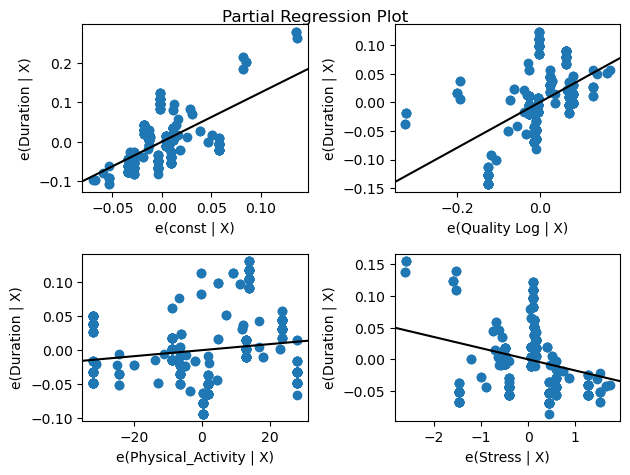

In [7]:
sm.graphics.plot_partregress_grid(reg_logged)
plt.show()

- The residual-covariate plots were good here, showing a random scatter around the line y=0. The residual-covariate plots for the non-transformed model also appeared random. 
- The partial regression plots, however, are scattered and the points lie only very approximately along the line - this means that the average value of the error is likely not zero, either in the transformed model (plots shown) or the original model (plots not shown)

#### Assumption: Variance of the Error is Constant ####

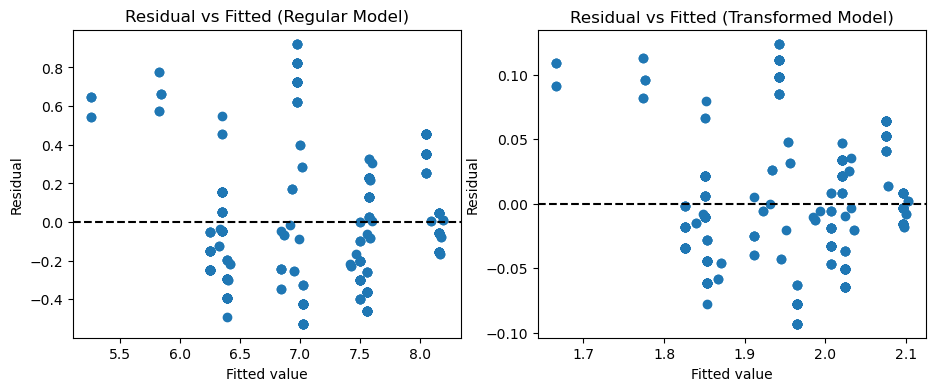

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
fitted_y = reg_original.fittedvalues
residuals = reg_original.resid
fitted_y_log = reg_logged.fittedvalues
residuals_log = reg_logged.resid
axes[0].scatter(fitted_y, residuals)
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].set_xlabel('Fitted value')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residual vs Fitted (Regular Model)')

axes[1].scatter(fitted_y_log,residuals_log)
axes[1].axhline(y=0, color='k', linestyle='--')
axes[1].set_xlabel('Fitted value')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual vs Fitted (Transformed Model)')
plt.show()

- The number of negative residuals increases from the left to the right in the regular model.
- The residuals in the transformed model are randomly scattered. The residuals are more evenly spread above and below the horizontal axiz.
- The lack of a perfect random scatter here can also partially be attributed to the integer values taken by the 'sleep quality' and 'stress level' variables

#### Assumption: Error is a random sample from a normal distribution ####

TODO:NEED FIx
- The QQ-plot of  transformed model follows the line $y=x$ more closely - between -1 and 1 it is quite good, although it deviates more significantly outside this range
- The rough S-shape of the non-transformed Q-Q plot suggests that the distribution of $\vec{\epsilon}$ is more light-tailed than a standard normal distribution - this is improved but not eradicated by the transformations

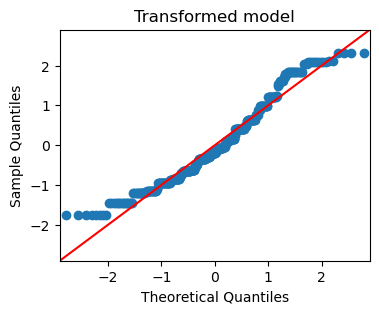

In [29]:
fig, ax = plt.subplots(figsize=(4, 3))
sm.qqplot(residuals_log, fit=True, line="45", ax = ax)
plt.title("Transformed model")
plt.show()


#### Assumption: Errors are independent

Our data is not time series data, so we are not able to run the residual vs index plot.

### Limitations of our Model ####

In [10]:
pd.concat((Y_log, X_transformed),axis = 1).corr()

,Duration,Quality Log,Physical_Activity,Stress
Duration,1.000000,0.869755,0.222198,-0.816515
Quality Log,0.869755,1.000000,0.215380,-0.882162
Physical_Activity,0.222198,0.215380,1.000000,-0.034134
Stress,-0.816515,-0.882162,-0.034134,1.000000


In [11]:
X_transformed.describe().loc[['min', '25%', '50%', '75%', 'max']]

,Quality Log,Physical_Activity,Stress
min,1.386294,30.0,3.0
25%,1.791759,45.0,4.0
50%,1.945910,60.0,5.0
75%,2.079442,75.0,7.0
max,2.197225,90.0,8.0
